# Kopp et al 2021 Intepretation
**Authorship:**
Adam Klie, *08/12/2022*
***
**Description:**
Notebook to interpret the best trained models on the Kopp et al (2021) dataset.
***

In [64]:
if 'autoreload' not in get_ipython().extension_manager.loaded:
    %load_ext autoreload 
%autoreload 2

In [1]:
# General imports
import os
import sys
import glob
import torch
import numpy as np
import xarray as xr
import torch.nn.functional as F

# EUGENe imports and settings
import eugene as eu
from eugene import preprocess as pp
from eugene import models
from eugene import interpret
from eugene import plot as pl
from eugene import settings
settings.dataset_dir = "/cellar/users/aklie/data/eugene/revision/kopp21"
settings.config_dir = "/cellar/users/aklie/projects/ML4GLand/EUGENe_paper/configs/kopp21"
settings.output_dir = "/cellar/users/aklie/projects/ML4GLand/EUGENe_paper/output/revision/kopp21/"
settings.logging_dir = "/cellar/users/aklie/projects/ML4GLand/EUGENe_paper/logs/revision/kopp21"
settings.figure_dir = "/cellar/users/aklie/projects/ML4GLand/EUGENe_paper/figures/revision/kopp21"

# EUGENe packages
import seqdata as sd
import motifdata as md
import seqpro as sp

# For illustrator editing
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# Print versions
print(f"Python version: {sys.version}")
print(f"NumPy version: {np.__version__}")
print(f"Xarray version: {xr.__version__}")
print(f"Eugene version: {eu.__version__}")
print(f"SeqData version: {sd.__version__}")
print(f"MotifData version: {md.__version__}")
print(f"SeqPro version: {sp.__version__}")
print(f"PyTorch version: {torch.__version__}")

/cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/lightning_utilities/core/imports.py:116: UserWarning: Unbuilt egg for seqpro [unknown version] (/cellar/users/aklie/projects/ML4GLand/SeqPro)
  pkg_resources.require(self.requirement)
/cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/lightning_utilities/core/imports.py:116: UserWarning: Unbuilt egg for seqpro [unknown version] (/cellar/users/aklie/projects/ML4GLand/SeqPro)
  pkg_resources.require(self.requirement)


Python version: 3.9.16 | packaged by conda-forge | (main, Feb  1 2023, 21:39:03) 
[GCC 11.3.0]
NumPy version: 1.23.5
Xarray version: 2023.4.0
Eugene version: 0.0.8
SeqData version: 0.0.1
MotifData version: 0.0.1
SeqPro version: None
PyTorch version: 2.0.0


# Load in the test `SeqData`

In [2]:
# Read in the predictions 
sdata_test = sd.open_zarr(os.path.join(settings.output_dir, "test_predictions_all.zarr")).load()

In [3]:
# Give the sequences a unique ID
sdata_test["id"] = sdata_test["chrom"] + ":" + sdata_test["chromStart"].astype(str) + "-" + sdata_test["chromEnd"].astype(str)

# Load the best model

In [4]:
# Define the model type and trial
model_type = "cnn"
trial = 4

In [5]:
# Load up the model form the checkpoint
model_file = glob.glob(os.path.join(settings.logging_dir, f"{model_type}", f"trial_{trial}", "checkpoints", "*"))[0]
model_arch = models.load_config(config_path=f"{model_type}.yaml")
model = models.SequenceModule.load_from_checkpoint(model_file, arch=model_arch.arch)

[rank: 0] Global seed set to 4


## Feature attribution

In [6]:
# Run GradientShap with a simple all 0s reference
method = "GradientShap"
interpret.attribute_sdata(
    model,
    sdata_test,
    method=method,
    batch_size=128,
    reference_type="zero",
    transforms={"ohe_seq": lambda x: torch.tensor(x, dtype=torch.float32).permute(0, 2, 1)}
)

Computing saliency on batches of size 128:   0%|          | 0/503 [00:00<?, ?it/s]

In [7]:
# Get the reverse complement of the one-hot encoded sequence
sdata_test["rc_ohe_seq"] = sp.reverse_complement(sdata_test["ohe_seq"], sp.ALPHABETS["DNA"], length_axis=1, ohe_axis=2)
interpret.attribute_sdata(
    model,
    sdata_test,
    method=method,
    batch_size=128,
    reference_type="zero",
    seq_key="rc_ohe_seq",
    transforms={"rc_ohe_seq": lambda x: torch.tensor(x, dtype=torch.float32).permute(0, 2, 1)},
    suffix="_rc"
)

Computing saliency on batches of size 128:   0%|          | 0/503 [00:00<?, ?it/s]

In [8]:
# From the top 10 predicted sequences, identify the positions where we see significant attribution signal
top10 = sdata_test[f"{model_type}_trial_{trial}_target_predictions"].to_series().sort_values(ascending=False).iloc[:10].index
top10_idx = np.argsort(sdata_test[f"{model_type}_trial_{trial}_target_predictions"].values)[::-1][:10]
ids = sdata_test["id"].values

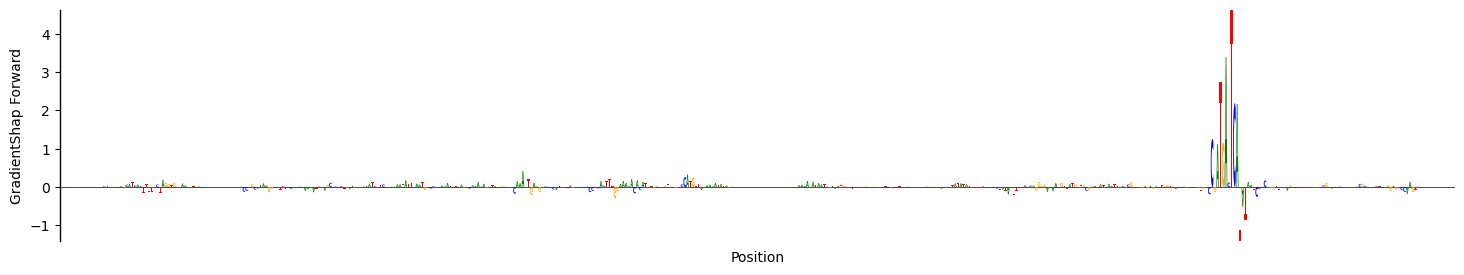

In [9]:
# Plot a test sequence
pl.seq_track(
    sdata_test,
    seq_id=ids[top10[0]],
    attrs_key="GradientShap_attrs",
    ylab="GradientShap Forward",
    figsize=(18, 3),
)

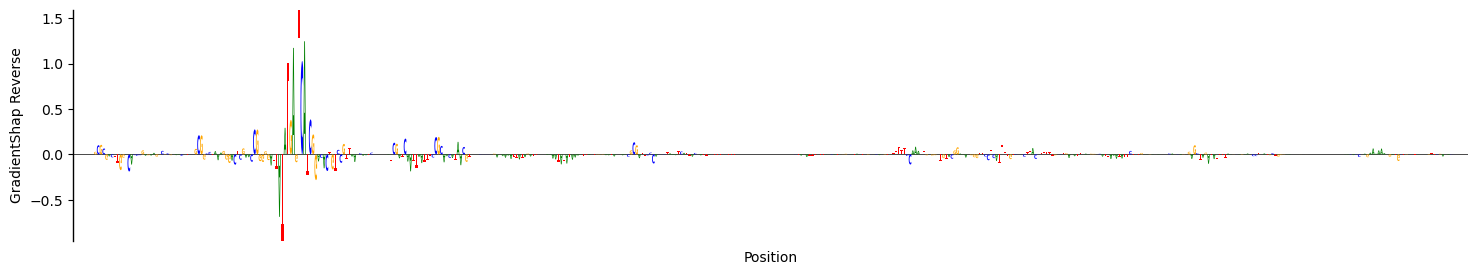

In [10]:
# Check the rev comp
pl.seq_track(
    sdata_test,
    seq_id=ids[top10[0]],
    attrs_key="GradientShap_attrs_rc",
    ylab="GradientShap Reverse",
    figsize=(18, 3),
)

## Filter viz (only for convnet)

In [12]:
if model_type == "kopp21_cnn":
    model.to("cuda")
    layer_name = "arch.conv"
    layer = models.get_layer(model, layer_name)
    seqs = sdata_test["ohe_seq"].transpose("_sequence", "_ohe", "length").to_numpy()
    seqs_torch = torch.tensor(seqs, dtype=torch.float32).to(model.device)
    activations = F.relu(layer(seqs_torch)).detach().cpu().numpy()
    transforms = None
else:
    layer_name = "arch.conv1d_tower.layers.1"
    transforms = {"ohe_seq": lambda x: torch.tensor(x, dtype=torch.float32).permute(0, 2, 1)}
    activations = None
    seqs = None
kernel_size = 11
num_filters = 10
num_seqlets = 100
layer_name, transforms

('arch.conv1d_tower.layers.1', {'ohe_seq': <function __main__.<lambda>(x)>})

In [13]:
# Generate pfms from filters
interpret.generate_pfms_sdata(
    model,
    sdata_test,
    seq_key="ohe_seq",
    layer_name=layer_name,
    activations=activations,
    seqs=seqs,
    kernel_size=11,
    num_filters=10,
    num_seqlets=100,
    transforms=transforms,
)

Getting activations on batches of size 128:   0%|          | 0/503 [00:00<?, ?it/s]

Getting filter activators for 10 filters:   0%|          | 0/10 [00:00<?, ?it/s]

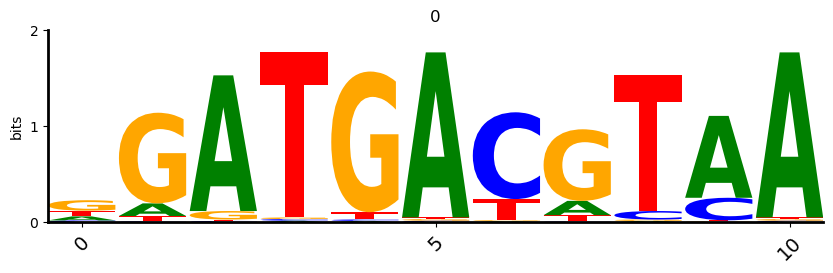

In [14]:
# Visualize a filter of choice
pl.filter_viz(
    sdata_test,
    filter_num=0,
    pfms_key=f"{layer_name}_pfms",
)

In [15]:
# Save all the filter pfms from above as meme format for submission to TomTom
interpret.filters_to_meme_sdata(
    sdata_test,
    filters_key=f"{layer_name}_pfms", 
    axis_order=(f"_{layer_name}_10_filters", "_ohe", f"_{layer_name}_11_kernel_size"),
    output_dir=os.path.join(settings.output_dir, model_type),
    filename=f"best_model_{model_type}_filters.meme"
)

Output directory already exists: /cellar/users/aklie/projects/ML4GLand/EUGENe_paper/output/revision/kopp21/cnn
Saved pfm in MEME format as: /cellar/users/aklie/projects/ML4GLand/EUGENe_paper/output/revision/kopp21/cnn/best_model_cnn_filters.meme


In [16]:
# Save the predictions and interpretations to zarr
sd.to_zarr(sdata_test, os.path.join(settings.output_dir, model_type, f"test_predictions_and_interpretations.zarr"), load_first=True, mode="w")

## In silico interpretation

In [17]:
# Prep feature from meme file
meme = md.read_meme(os.path.join(settings.dataset_dir, "MA0491.1.meme"))
motif = meme.motifs["MA0491.1"]
feat_name = motif.name
pfm = motif.pfm
consensus = motif.consensus
consensus_ohe = sp.ohe(consensus, sp.ALPHABETS["DNA"])
pfm.shape, consensus_ohe.shape

((11, 4), (11, 4))

In [18]:
# Get some background sequences
zero_pfm = np.zeros(pfm.shape)
rand_pfm = sp.ohe(sp.random_seq(pfm.shape[0]), alphabet=sp.ALPHABETS["DNA"])
shuffled_pfm = sp.ohe(sp.k_shuffle(consensus, k=1).tobytes().decode(), alphabet=sp.ALPHABETS["DNA"])
zero_pfm.shape, rand_pfm.shape, shuffled_pfm.shape

((11, 4), (11, 4), (11, 4))

In [19]:
# Random seqs to implant into
random_seqs = sp.ohe(sp.random_seqs(10, 500), alphabet=sp.ALPHABETS["DNA"]).transpose(0, 2, 1)
sdata_implant = xr.Dataset({"ohe_seq": xr.DataArray(random_seqs, dims=("_sequence", "_ohe", "length"))})
pp.make_unique_ids_sdata(sdata_implant, id_var="name")

In [20]:
# Slide the JUND motif across the sequences
interpret.positional_gia_sdata(
    model,
    sdata_implant,
    seq_key="ohe_seq",
    id_key="name",
    feature=consensus_ohe,
    feature_name=feat_name,
    encoding="onehot",
    store_key=f"slide_{feat_name}",
)

# Slide a random seq across the sequences
interpret.positional_gia_sdata(
    model,
    sdata_implant,
    seq_key="ohe_seq",
    id_key="name",
    feature=rand_pfm,
    feature_name="random",
    encoding="onehot",
    store_key=f"slide_random",
)

# Slide a zero ohe seq across the sequences 
interpret.positional_gia_sdata(
    model,
    sdata_implant,
    seq_key="ohe_seq",
    id_key="name",
    feature=zero_pfm,
    feature_name="zero",
    encoding="onehot",
    store_key=f"slide_zero",
)

# Slide a TATA shuffled ohe seq across the sequences
interpret.positional_gia_sdata(
    model,
    sdata_implant,
    seq_key="ohe_seq",
    id_key="name",
    feature=shuffled_pfm,
    feature_name="shuffled",
    encoding="onehot",
    store_key=f"slide_shuffled",
)   

Implanting feature in all seqs of sdata:   0%|          | 0/10 [00:00<?, ?it/s]

Implanting feature in all seqs of sdata:   0%|          | 0/10 [00:00<?, ?it/s]

Implanting feature in all seqs of sdata:   0%|          | 0/10 [00:00<?, ?it/s]

Implanting feature in all seqs of sdata:   0%|          | 0/10 [00:00<?, ?it/s]

In [21]:
# Get the original predictions values
orig_preds = model.predict(torch.tensor(sdata_implant["ohe_seq"].values, dtype=torch.float32).to(model.device)).detach().cpu().numpy()

Predicting on batches: 0it [00:00, ?it/s]

In [22]:
np.min(orig_preds), np.max(orig_preds)

(-4.4636154, -1.4238142)

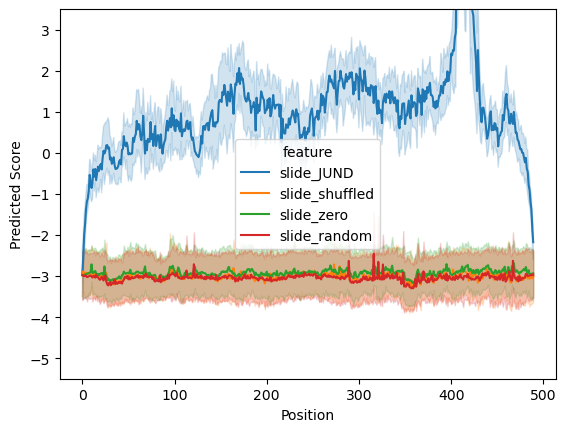

In [23]:
# Plot the implanted scores across positions
ax = pl.positional_gia_plot(
    sdata_implant,
    keys=[f"slide_{feat_name}", "slide_shuffled", "slide_zero", "slide_random"],
    id_key="name",
    save=os.path.join(eu.settings.figure_dir, model_type, f"best_{model_type}_model_feature_implant_jund.pdf"),
    ylim=(-5.5, 3.5),
    return_axes=True
)

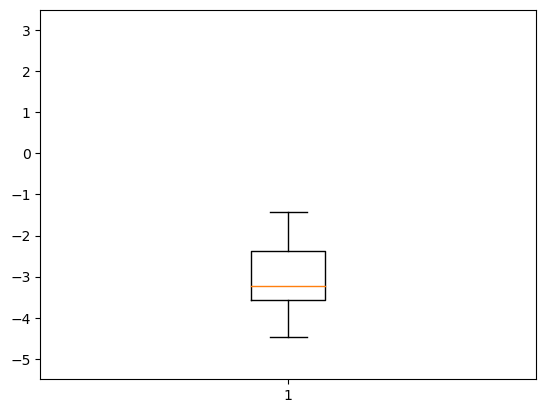

In [24]:
# Plot the original scores for the sequences
plt.boxplot(orig_preds)
plt.ylim(-5.5, 3.5)
plt.savefig(os.path.join(eu.settings.figure_dir, model_type, f"best_{model_type}_model_random_seq_scores.pdf"))

In [25]:
# Save the evolved sequences  with the TATA implanted scores as well
sd.to_zarr(sdata_implant, os.path.join(settings.output_dir, model_type, f"implant_JUND_{model_type}.zarr"), load_first=True, mode="w")

# DONE!

---

# Scratch